In [2]:
# 1. import module

import pandas as pd
import sklearn
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import MinMaxScaler
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import time

from pycaret.regression import *

from sklearn.model_selection import train_test_split 
from sklearn import metrics
from lightgbm import LGBMRegressor
import lightgbm as lgb
from sklearn.model_selection import KFold

from sklearn.metrics import r2_score
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error 


pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
pd.options.display.max_seq_items = None



from py_module.load_data import load_data
from py_module.plot_data import plot_histogram
from py_module.regression import *
from py_module.pre_processing import *
from py_module.verify import *
from py_module.etc import *
from py_module.compare import *


개수: 3868
개수: 3823
<class 'list'>
LGBMRegressor(learning_rate=0.05, n_estimators=10000, random_state=765)


['Rr_0620.pkl']

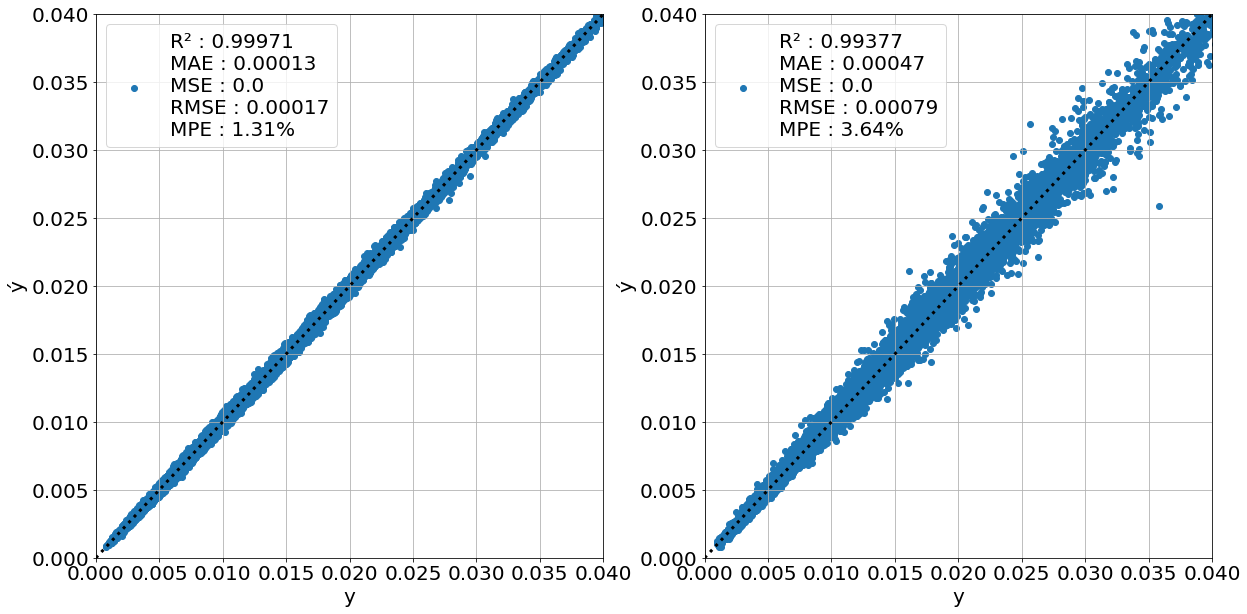

In [26]:
# 2. one-click

raw_data = np.loadtxt("../data/loss_20220620_130609_N95274.csv",delimiter=",")

column_names = ["N1","w1","l1","l2","h1","per","space1","space2","space3","space4","coil_width1","coil_width2","move_z1","move_z2","offset_z1","offset_z2","null","freq","Rt","Rr"]

pd_data = pd.DataFrame(raw_data, columns=column_names)


# 7. define outlier search function
def get_outlier(df=None, column=None, weight=1.5):
    
    # column 데이터만 추출, 1/4 분위와 3/4 분위 지점을 np.percentile로 구함. 
    data = df[column]
    quantile_25 = np.percentile(data.values, 25)  # 1/4 분위
    quantile_75 = np.percentile(data.values, 75)  # 3/4 분위
    
    # IQR을 구하고, IQR에 1.5를 곱하여 최대값과 최소값 지점 구함. 
    iqr = quantile_75 - quantile_25
    iqr_weight = iqr * weight
    lowest_val = quantile_25 - iqr_weight  # 이상치 최소 기준
    highest_val = quantile_75 + iqr_weight # 이상치 최대 기준
    
    # 최대값 보다 크거나, 최소값 보다 작은 값을 아웃라이어로 설정하고 DataFrame index 반환. 
    outlier_index = data[(data < lowest_val) | (data > highest_val)].index
    
    return outlier_index

col_input = list(pd_data.columns)[:-3]
#col_input = list(pd_data.columns)

# outlier 탐색 및 제거
outlier_index = {}
for i, colName in enumerate(col_input):
     outlier_index[i] = get_outlier(df=pd_data, column=f'{colName}', weight=1.5)
outlier_index

# 각각의 숫자들 리스트 안에 넣기
outlier_list = []
for i in range(len(outlier_index)):
    if list(outlier_index[i].values) == []:
        continue
    outlier_list.append(list(outlier_index[i].values))


# 리스트 안의 리스트들을 하나로 합치기
outlier_list = sum(outlier_list , [])
print('개수:', len(outlier_list))

# 중복 숫자 제거
outlier_list = set(outlier_list)
print('개수:', len(outlier_list))

# 다시 리스트 타입으로 변환
outlier_list = list(outlier_list)
print(type(outlier_list))

# 리스트 숫자 정렬
outlier_list.sort()

# outlier를 갖는 index에 해당하는 data drop
for i in outlier_list:
    pd_data.drop(i, axis=0, inplace=True)
pd_data.shape


# split input/output

X = pd_data.drop(columns="freq").drop(columns="null").drop(columns="Rt").drop(columns="Rr")
Y = pd_data["Rr"]/100**2

X_train,X_test,Y_train,Y_test = train_test_split(X,Y,test_size=0.2,random_state = 765)


model = LGBMRegressor(random_state=765, n_estimators=10000, learning_rate=0.05, num_leaves=31)
model.fit(X_train,Y_train)

print(model)

train_data = pd.concat([X_train,pd.DataFrame(Y_train)], axis=1)

test_data = pd.concat([X_test,pd.DataFrame(Y_test)], axis=1)


train_data.head()

parameter = "Rr"

verify_plot(model, train_data, test_data, parameter, xlim=[0,0.04], ylim=[0,0.04], legend=True)

import joblib

#joblib.dump(model, 'Rr_0620.pkl')


In [2]:
# 2. data import

#raw_data = np.loadtxt("../data/loss_20220608_105250_N14183.csv",delimiter=",")
#raw_data = np.loadtxt("../data/loss_20220609_130342_N39022.csv",delimiter=",")
raw_data = np.loadtxt("../data/loss_20220614_160402_N35241.csv",delimiter=",")
#raw_data = np.loadtxt("../data/coupling.csv",delimiter=",")
#raw_data = np.loadtxt("../data/loss.csv",delimiter=",")

column_names = ["N1","w1","l1","l2","h1","per","space1","space2","space3","space4","coil_width1","coil_width2","move_z1","move_z2","offset_z1","offset_z2","null","freq","Rt","Rr"]
#column_names = ["width0","width1","height0","height1","move","coil0_width","coil1_width","gap0","gap1","freq","k12","k13","k23"]
#column_names = ["width0","width1","height0","height1","move","coil0_width","coil1_width","gap0","gap1","0","freq","loss1","loss2","loss3"]

pd_data = pd.DataFrame(raw_data, columns=column_names)

pd_data.head()


,N1,w1,l1,l2,h1,per,space1,space2,space3,space4,coil_width1,coil_width2,move_z1,move_z2,offset_z1,offset_z2,null,freq,Rt,Rr
0,11.0,166.0,43.0,69.0,200.0,3300.0,16.0,26.0,25.0,20.0,3.0,10.0,2.5,3.0,-7.5,14.5,0.0,30.0,251.367058,269.043795
1,15.0,76.0,16.0,61.0,252.0,8400.0,25.0,13.0,50.0,24.0,10.0,3.0,2.0,2.0,-18.0,-4.0,0.0,30.0,327.614969,311.281943
2,2.0,113.0,42.0,95.0,53.0,4000.0,26.0,44.0,21.0,35.0,4.0,5.0,3.0,5.0,10.0,-16.5,0.0,30.0,50.357962,36.157971
3,12.0,135.0,21.0,70.0,120.0,7000.0,40.0,36.0,36.0,15.0,2.5,5.0,3.0,2.0,12.5,4.5,0.0,30.0,340.048707,242.301735
4,6.0,137.0,16.0,86.0,106.0,3200.0,4.0,26.0,34.0,46.0,7.0,2.0,3.0,2.5,-11.0,-7.5,0.0,30.0,81.272008,233.304800


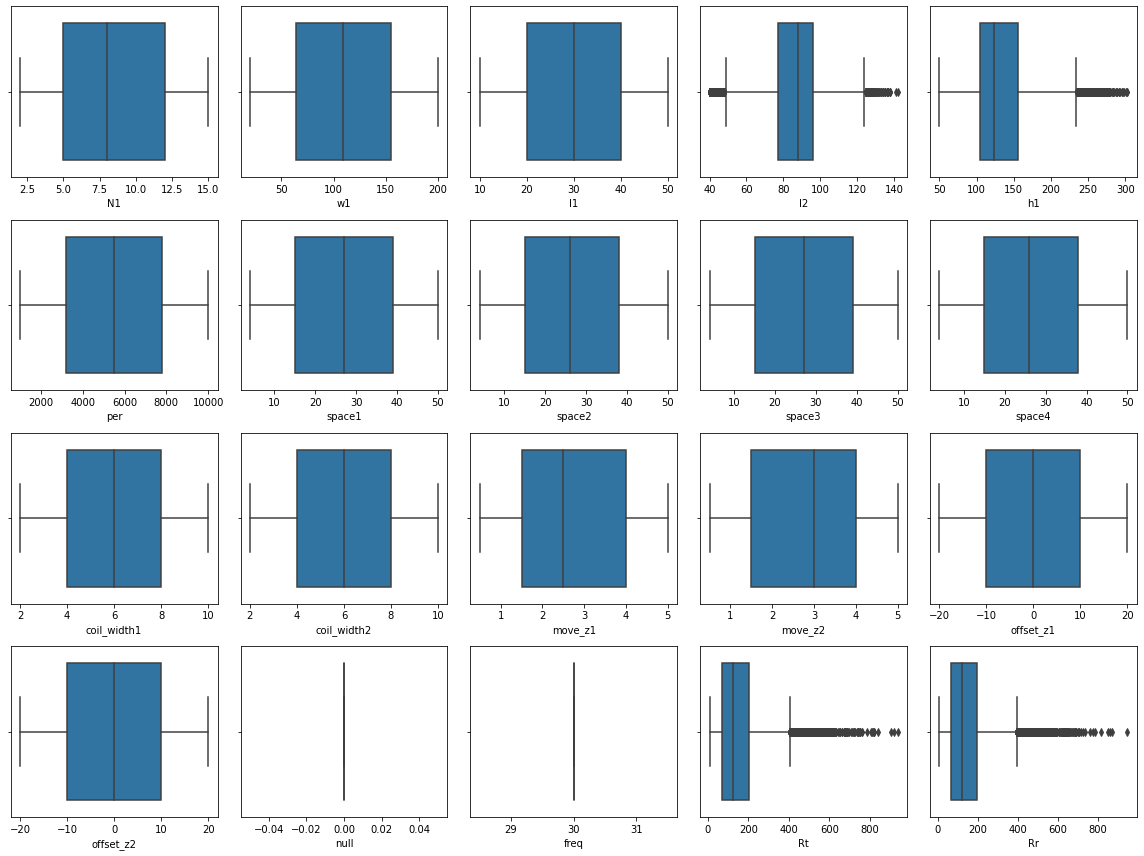

In [3]:
# 4. check outlier

plt.figure(figsize=(16, 12))
for i, colName in enumerate(list(pd_data.columns)) :
    plt.subplot(4, 5, i+1)
    sns.boxplot(x=pd_data.loc[:, colName])
plt.tight_layout()
plt.show()

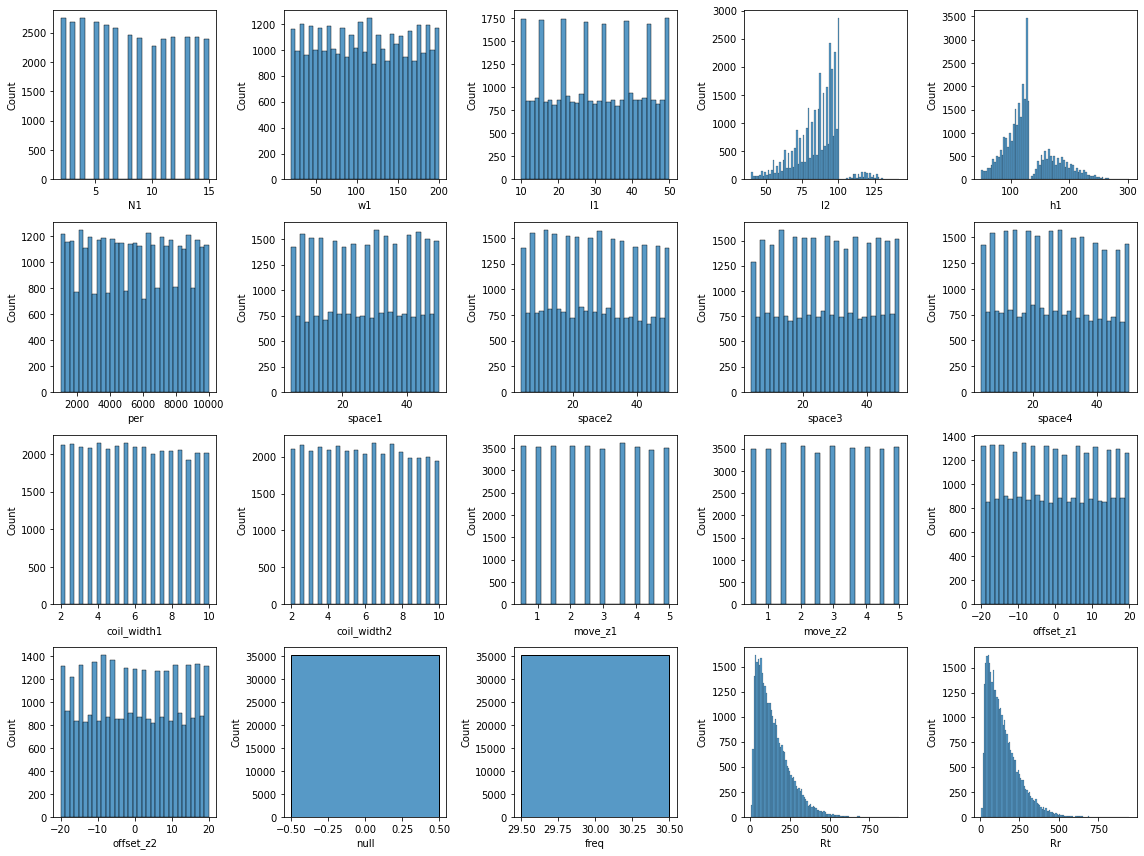

In [4]:
# 5. check data distribution

plt.figure(figsize=(16, 12))
for i, colName in enumerate(list(pd_data.columns)) :
    plt.subplot(4, 5, i+1)
    sns.histplot(pd_data.loc[:, colName])
plt.tight_layout()
plt.show()

In [5]:
# 7. define outlier search function
def get_outlier(df=None, column=None, weight=1.5):
    
    # column 데이터만 추출, 1/4 분위와 3/4 분위 지점을 np.percentile로 구함. 
    data = df[column]
    quantile_25 = np.percentile(data.values, 25)  # 1/4 분위
    quantile_75 = np.percentile(data.values, 75)  # 3/4 분위
    
    # IQR을 구하고, IQR에 1.5를 곱하여 최대값과 최소값 지점 구함. 
    iqr = quantile_75 - quantile_25
    iqr_weight = iqr * weight
    lowest_val = quantile_25 - iqr_weight  # 이상치 최소 기준
    highest_val = quantile_75 + iqr_weight # 이상치 최대 기준
    
    # 최대값 보다 크거나, 최소값 보다 작은 값을 아웃라이어로 설정하고 DataFrame index 반환. 
    outlier_index = data[(data < lowest_val) | (data > highest_val)].index
    
    return outlier_index

col_input = list(pd_data.columns)[:-3]
#col_input = list(pd_data.columns)

# outlier 탐색 및 제거
outlier_index = {}
for i, colName in enumerate(col_input):
     outlier_index[i] = get_outlier(df=pd_data, column=f'{colName}', weight=1.5)
outlier_index

# 각각의 숫자들 리스트 안에 넣기
outlier_list = []
for i in range(len(outlier_index)):
    if list(outlier_index[i].values) == []:
        continue
    outlier_list.append(list(outlier_index[i].values))


# 리스트 안의 리스트들을 하나로 합치기
outlier_list = sum(outlier_list , [])
print('개수:', len(outlier_list))

# 중복 숫자 제거
outlier_list = set(outlier_list)
print('개수:', len(outlier_list))

# 다시 리스트 타입으로 변환
outlier_list = list(outlier_list)
print(type(outlier_list))

# 리스트 숫자 정렬
outlier_list.sort()

# outlier를 갖는 index에 해당하는 data drop
for i in outlier_list:
    pd_data.drop(i, axis=0, inplace=True)
pd_data.shape

개수: 1514
개수: 1498
<class 'list'>


(33743, 20)

In [8]:
col_input

['N1',
 'w1',
 'l1',
 'l2',
 'h1',
 'space1',
 'space2',
 'space3',
 'space4',
 'coil_width1',
 'coil_width2',
 'move_z1',
 'move_z2',
 'offset_z1',
 'offset_z2',
 'null',
 'freq',
 'Rt',
 'Rr']

In [9]:
# split input/output

X = pd_data.drop(columns="freq").drop(columns="null").drop(columns="Rt").drop(columns="Rr")
Y = pd_data["Rr"]/100**2

#X = pd_data.drop(columns="k12").drop(columns="k13").drop(columns="k23")
#Y = pd_data["k12"]

#X = pd_data.drop(columns="loss1").drop(columns="loss2").drop(columns="loss3")
#Y = pd_data["loss1"]

X_train,X_test,Y_train,Y_test = train_test_split(X,Y,test_size=0.2,random_state = 765)

LGBMRegressor(learning_rate=0.05, n_estimators=2000, random_state=765)


['Rr_0614.pkl']

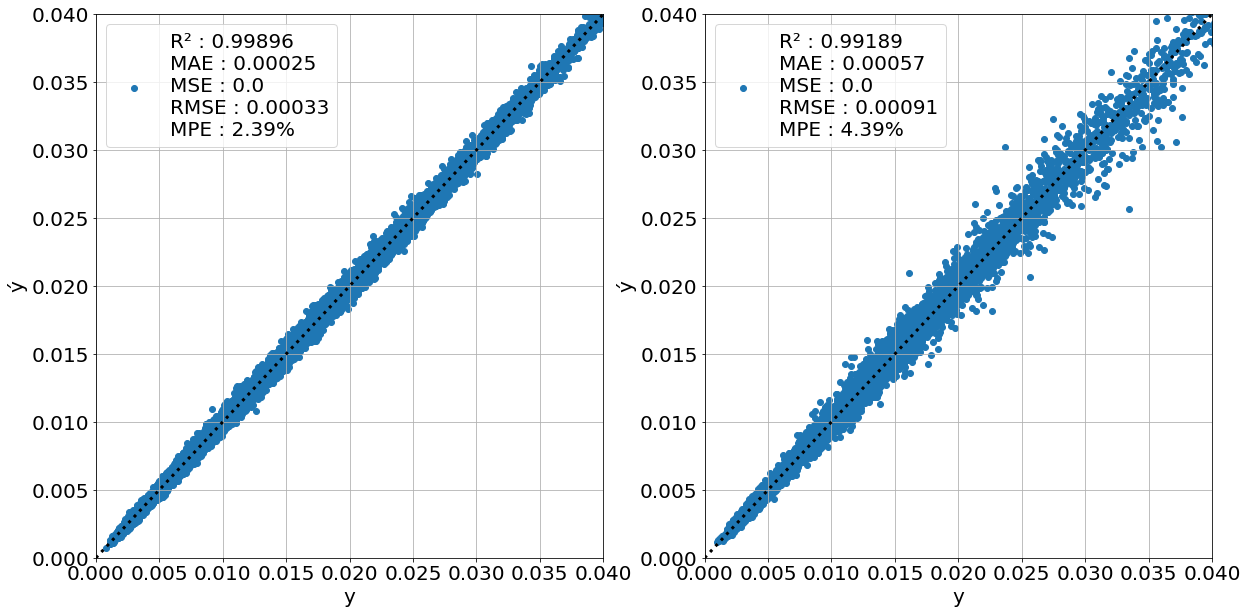

In [11]:
#model = LGBMRegressor(random_state=765, n_estimators=2000, learning_rate=0.05, num_leaves=31)
model = LGBMRegressor(random_state=765, n_estimators=2000, learning_rate=0.05, num_leaves=31)
model.fit(X_train,Y_train)

print(model)

train_data = pd.concat([X_train,pd.DataFrame(Y_train)], axis=1)

test_data = pd.concat([X_test,pd.DataFrame(Y_test)], axis=1)


train_data.head()

parameter = "Rr"

verify_plot(model, train_data, test_data, parameter, xlim=[0,0.04], ylim=[0,0.04], legend=True)

import joblib

#joblib.dump(model, 'Rr_0614.pkl')

[0.9835095628771242, 0.0006197361893878094, 1.0310594169226954e-06, 0.0010154109596230954, 5.914521780915411, -1.0218433213156237]
[0.9858230889699623, 0.0006039767839156086, 9.127109093853735e-07, 0.0009553590473666817, 5.929675874957326, -0.7075233796605966]
[0.9846952770239967, 0.000640096956618053, 9.99558043607864e-07, 0.0009997789973828536, 6.3150853621528755, -0.6696214679804396]
[0.9862131247918617, 0.0006074677489112222, 8.613059456550954e-07, 0.0009280657011521842, 5.824517583694086, -0.4191820478493876]
[0.9860474727854429, 0.0005880262399745124, 8.575093129834615e-07, 0.0009260179873973623, 6.08260761641221, -0.7791489629688283]


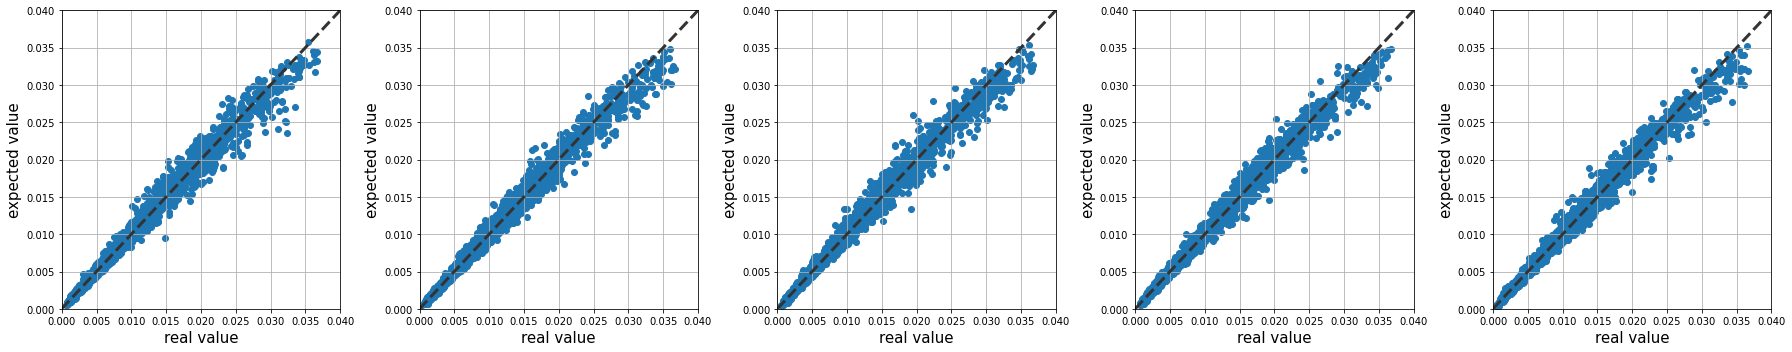

In [8]:
col_input = list(X.columns)

# 교차 검증용 데이터셋 구성
df_trains = []
df_valids = []

# MAPE 정의
def def_MAPE(y_test, y_pred):
	return np.mean(np.abs((y_test - y_pred) / y_test)) * 100 

# MPE 정의
def def_MPE(y_test, y_pred): 
	return np.mean((y_test - y_pred) / y_test) * 100

# KFold 검증
i = 0
plt.figure(figsize=(25, 5))
kfold = KFold(n_splits=5, random_state=765, shuffle=True)
for train_idx, test_idx in kfold.split(X[col_input]):

    # fold 후 train, test set 분할
    X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
    Y_train, Y_test = Y.iloc[train_idx], Y.iloc[test_idx]

    # regression model 생성
    model.fit(X_train, Y_train)

    # 예측
    fold_pred = model.predict(X_test)

    # 성능계산
    R2 = r2_score(Y_test, fold_pred)
    MAE = mean_absolute_error(Y_test, fold_pred)
    MSE = mean_squared_error(Y_test, fold_pred)
    RMSE = np.sqrt(MSE)
    MAPE = def_MAPE(Y_test, fold_pred)
    MPE = def_MPE(Y_test, fold_pred)

    print([R2, MAE,MSE,RMSE,MAPE,MPE])

    plt.subplot(1, 5, i+1)
    plt.scatter(Y_test, fold_pred)
    plt.xlabel("real value", fontsize=15)
    plt.ylabel("expected value", fontsize=15)
    plt.grid(True)
    plt.xlim(0, 0.04)
    plt.ylim(0, 0.04)
    plt.plot([0, 0.04], [0, 0.04], ls="--", c=".2", linewidth=3.0)
    i = i+1

plt.tight_layout()
plt.show()

In [20]:
from sklearn.model_selection import GridSearchCV

parameters = {
    "n_estimators" : [1000,3000,10000],
    'n_jobs' : [-1],
    'learning_rate': [0.05],
    'max_depth' : [-1,2,3,4,5,10,20,30,50],
    'num_leaves' : [31,60,80,100,127],
    }

#cv=5 5번의 교차검증.
grid = GridSearchCV(LGBMRegressor(random_state=0), verbose=2, param_grid = parameters, cv=kfold)
grid.fit(X_train, Y_train)

Fitting 5 folds for each of 135 candidates, totalling 675 fits
[CV] learning_rate=0.05, max_depth=-1, n_estimators=1000, n_jobs=-1, num_leaves=31 


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV]  learning_rate=0.05, max_depth=-1, n_estimators=1000, n_jobs=-1, num_leaves=31, total=   9.4s
[CV] learning_rate=0.05, max_depth=-1, n_estimators=1000, n_jobs=-1, num_leaves=31 


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    9.3s remaining:    0.0s


[CV]  learning_rate=0.05, max_depth=-1, n_estimators=1000, n_jobs=-1, num_leaves=31, total=  11.4s
[CV] learning_rate=0.05, max_depth=-1, n_estimators=1000, n_jobs=-1, num_leaves=31 
[CV]  learning_rate=0.05, max_depth=-1, n_estimators=1000, n_jobs=-1, num_leaves=31, total=   3.6s
[CV] learning_rate=0.05, max_depth=-1, n_estimators=1000, n_jobs=-1, num_leaves=31 
[CV]  learning_rate=0.05, max_depth=-1, n_estimators=1000, n_jobs=-1, num_leaves=31, total=   3.7s
[CV] learning_rate=0.05, max_depth=-1, n_estimators=1000, n_jobs=-1, num_leaves=31 
[CV]  learning_rate=0.05, max_depth=-1, n_estimators=1000, n_jobs=-1, num_leaves=31, total=   1.5s
[CV] learning_rate=0.05, max_depth=-1, n_estimators=1000, n_jobs=-1, num_leaves=60 
[CV]  learning_rate=0.05, max_depth=-1, n_estimators=1000, n_jobs=-1, num_leaves=60, total=   2.1s
[CV] learning_rate=0.05, max_depth=-1, n_estimators=1000, n_jobs=-1, num_leaves=60 
[CV]  learning_rate=0.05, max_depth=-1, n_estimators=1000, n_jobs=-1, num_leaves=60, 

[Parallel(n_jobs=1)]: Done 675 out of 675 | elapsed: 48.0min finished


GridSearchCV(cv=KFold(n_splits=5, random_state=765, shuffle=True),
             estimator=LGBMRegressor(random_state=0),
             param_grid={'learning_rate': [0.05],
                         'max_depth': [-1, 2, 3, 4, 5, 10, 20, 30, 50],
                         'n_estimators': [1000, 3000, 10000], 'n_jobs': [-1],
                         'num_leaves': [31, 60, 80, 100, 127]},
             verbose=2)

In [22]:
grid.best_params_

{'learning_rate': 0.05,
 'max_depth': 4,
 'n_estimators': 10000,
 'n_jobs': -1,
 'num_leaves': 31}

In [23]:
#model = LGBMRegressor(random_state=765, learning_rate=0.05, max_depth=10, n_estimators=5000)
tuned_model = LGBMRegressor(random_state=765, **grid.best_params_)
tuned_model.fit(X_train,Y_train)

print(tuned_model)

LGBMRegressor(learning_rate=0.05, max_depth=4, n_estimators=10000,
              random_state=765)


[0.9958255566144492, 0.9140250937075481, 1.9941484544223416, 1.4121432131417626, 4.949711517847335, 0.002318099733269799]
[0.9954067757918389, 0.9500328800056479, 2.252135805418638, 1.5007117662691387, 4.881763796540582, -0.028577398065501528]
[0.995688961094157, 0.9443259502352217, 2.068698070153125, 1.4382969339302385, 4.961097882169882, -0.3890619051306933]
[0.9963029117734534, 0.889377177241239, 1.8267548140643102, 1.3515749383827411, 5.032781846390559, -0.016524105625636925]
[0.9957007888645959, 0.9235714194097383, 2.0459684638366453, 1.430373539966622, 5.003386000144607, -0.17458481899094844]


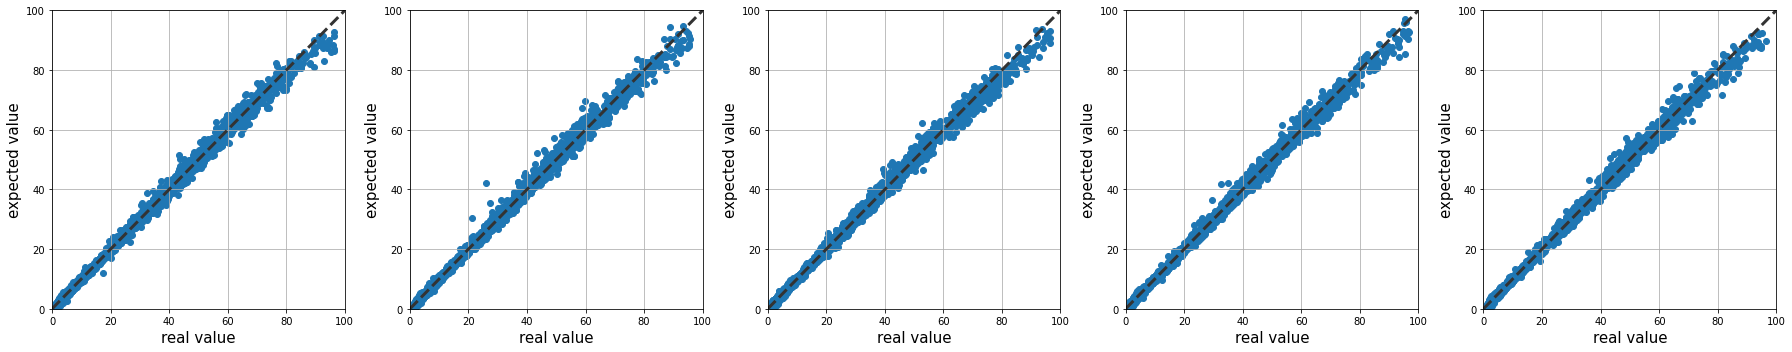

In [25]:
# 교차 검증용 데이터셋 구성
df_trains = []
df_valids = []

# MAPE 정의
def def_MAPE(y_test, y_pred):
	return np.mean(np.abs((y_test - y_pred) / y_test)) * 100 

# MPE 정의
def def_MPE(y_test, y_pred): 
	return np.mean((y_test - y_pred) / y_test) * 100

# KFold 검증
i = 0
plt.figure(figsize=(25, 5))
kfold = KFold(n_splits=5, random_state=765, shuffle=True)
for train_idx, test_idx in kfold.split(X[col_input]):

    # fold 후 train, test set 분할
    X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
    Y_train, Y_test = Y.iloc[train_idx], Y.iloc[test_idx]

    # regression model 생성
    tuned_model.fit(X_train, Y_train)

    # 예측
    fold_pred = tuned_model.predict(X_test)

    # 성능계산
    R2 = r2_score(Y_test, fold_pred)
    MAE = mean_absolute_error(Y_test, fold_pred)
    MSE = mean_squared_error(Y_test, fold_pred)
    RMSE = np.sqrt(MSE)
    MAPE = def_MAPE(Y_test, fold_pred)
    MPE = def_MPE(Y_test, fold_pred)

    print([R2, MAE,MSE,RMSE,MAPE,MPE])

    plt.subplot(1, 5, i+1)
    plt.scatter(Y_test, fold_pred)
    plt.xlabel("real value", fontsize=15)
    plt.ylabel("expected value", fontsize=15)
    plt.grid(True)
    plt.xlim(0, 100)
    plt.ylim(0, 100)
    plt.plot([0, 100], [0, 100], ls="--", c=".2", linewidth=3.0)
    i = i+1

plt.tight_layout()
plt.show()

In [15]:
train_data = pd.concat([X_train,pd.DataFrame(Y_train)], axis=1)

test_data = pd.concat([X_test,pd.DataFrame(Y_test)], axis=1)


train_data.head()

,N1,w1,l1,l2,h1,per,space1,space2,space3,space4,coil_width1,coil_width2,move_z1,move_z2,offset_z1,offset_z2,Rr
3790,13.0,111.0,31.0,86.0,166.0,4900.0,38.0,40.0,43.0,33.0,2.0,6.5,5.0,2.0,5.5,17.0,0.024139
12737,9.0,117.0,36.0,94.0,114.0,10000.0,10.0,35.0,44.0,31.0,5.0,5.5,4.5,1.0,3.5,-12.0,0.015712
6817,7.0,119.0,19.0,96.0,90.0,10000.0,27.0,43.0,6.0,38.0,7.0,2.5,3.5,2.0,-6.5,-13.0,0.016363
14085,4.0,56.0,19.0,92.0,123.0,9900.0,36.0,15.0,10.0,41.0,8.0,4.0,3.0,0.5,-19.0,-4.0,0.005941
632,11.0,106.0,38.0,90.0,128.0,7500.0,21.0,28.0,15.0,25.0,5.5,3.0,2.5,5.0,-16.5,4.5,0.018390


array([9.86139232e-01, 6.87766455e-04, 1.39518008e-06, 1.18117741e-03,
       5.03566013e+00])

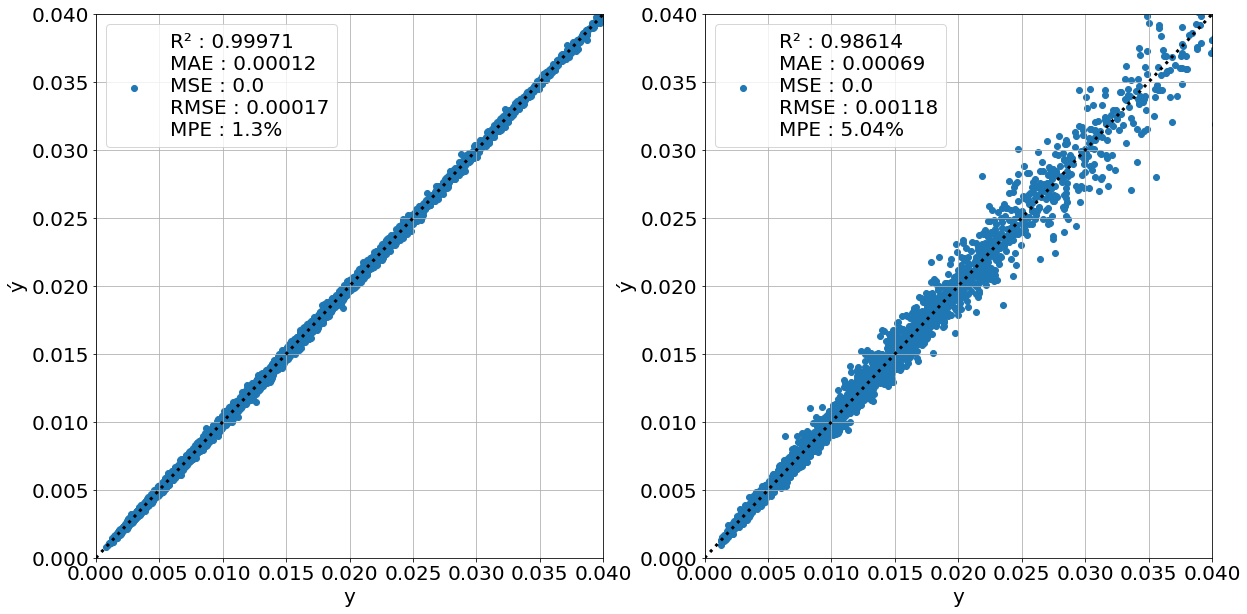

In [16]:
parameter = "Rr"

verify_plot(model, train_data, test_data, parameter, xlim=[0,0.04], ylim=[0,0.04], legend=True)

array([0.99328528, 1.06612185, 3.19549591, 1.78759501, 4.34227695])

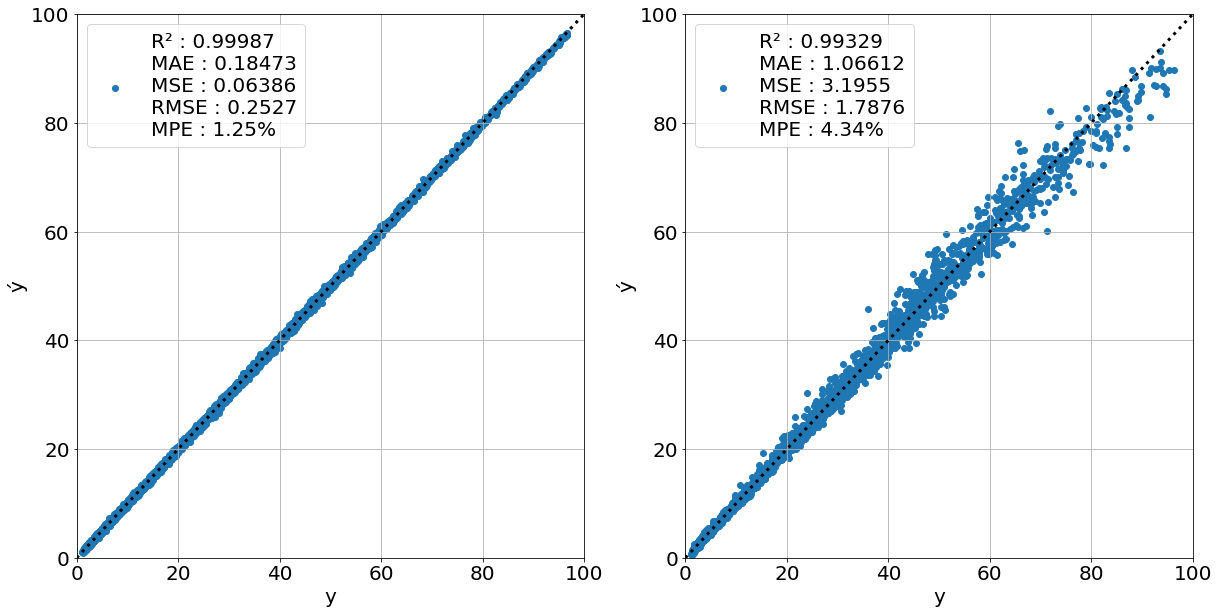

In [53]:
verify_plot(model, train_data, test_data, parameter, xlim=[0,100], ylim=[0,100], legend=True)

<AxesSubplot:title={'center':'Feature importance'}, xlabel='Feature importance', ylabel='Features'>

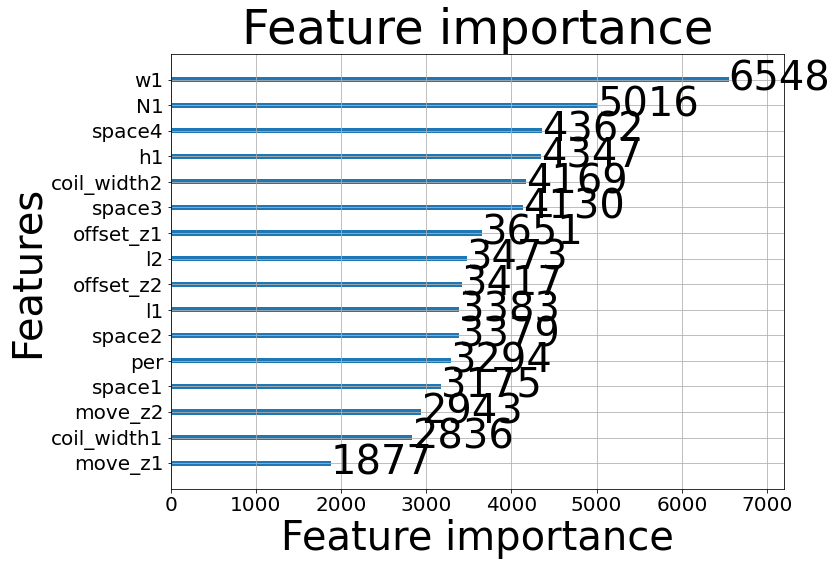

In [17]:
from lightgbm import plot_importance

fig, ax = plt.subplots(figsize=(11,8))
plot_importance(model, ax)

In [18]:
import joblib

joblib.dump(model, 'Rr_0613.pkl')

['Rr_0613.pkl']

In [89]:
load_model = joblib.load('leakage_inductance.pkl')

array([0.99570079, 0.92357142, 2.04596846, 1.43037354, 5.003386  ])

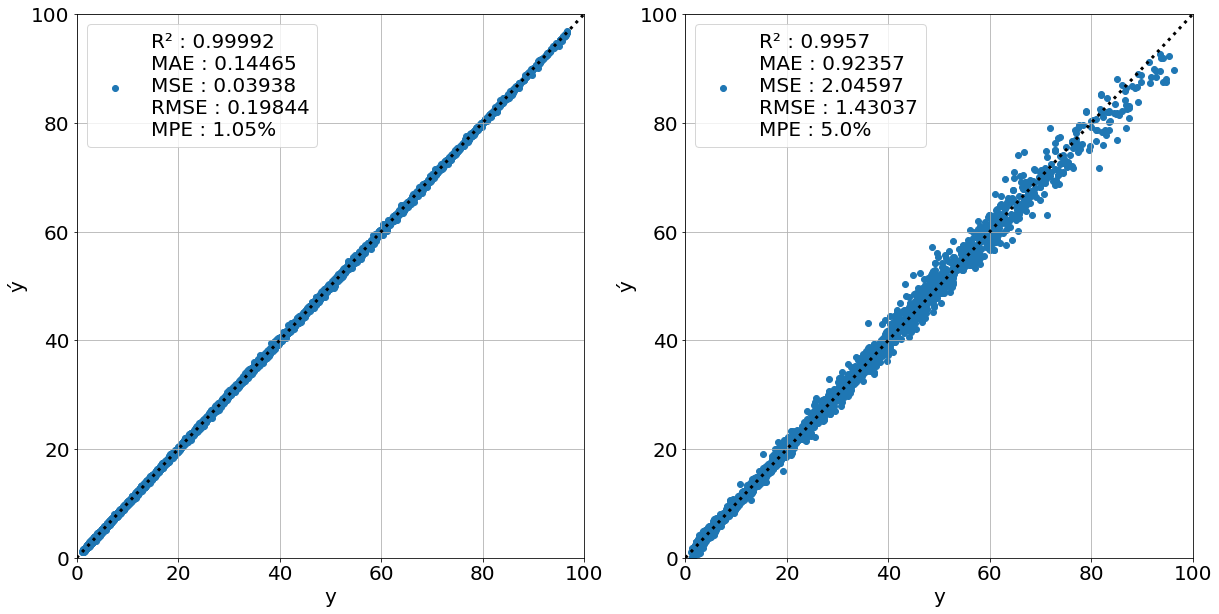

In [90]:
verify_plot(load_model, train_data, test_data, parameter, xlim=[0,100], ylim=[0,100], legend=True)